In [1]:
# imports required for the algorithm
import os

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# path to load and save data
data_input_path = '../data_in/CE_Crateus.csv'
data_output_path = '../data_out/weather.csv'
data_output_path_npsave = '../data_out/weather.npy'

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path, output_path):
    try:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # replaces first line NA values with next line value
    dataset.iloc[0,:].fillna(dataset.iloc[1,:], inplace=True)
    
    # replace all NA values with prev line value
    dataset.ffill(axis=0, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset)
        
    # save file
    dataset.to_csv(output_path)

format_dataset(data_input_path, data_output_path)

            Precipitacao  TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                                            
2015-01-01           0.0        35.0        23.7        5.9              10.2   
2015-01-02           0.0        35.8        23.0       10.6              10.2   
2015-01-03          37.4        31.9        22.3        4.3               6.2   
2015-01-04          12.4        27.3        20.7        1.9               3.5   
2015-01-05          23.0        32.4        20.7        8.3               1.5   
...                  ...         ...         ...        ...               ...   
2018-04-26           0.0        31.0        20.8        8.9               0.5   
2018-04-27           0.0        31.7        22.9       10.5               0.5   
2018-04-28           0.0        31.3        21.5        9.5               0.5   
2018-04-29           3.5        28.9        22.7        2.5               0.5   
2018-04-30           0.4    

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

dataset = load_dataset(data_output_path)
values = dataset.values

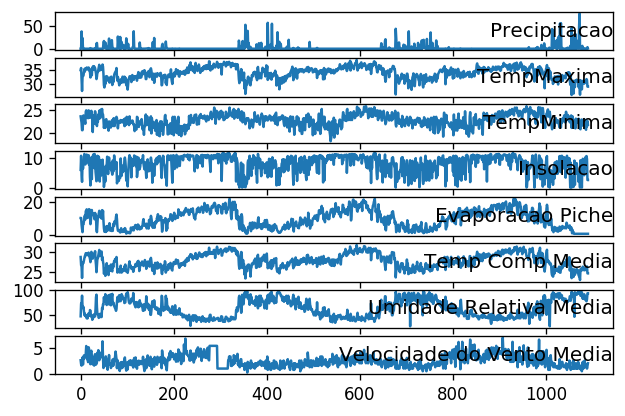

In [6]:
# plot each column in a graph
def plot_columns(values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [7]:
# convert series to supervised learning
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,8)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,8)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,8)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return [x_train, y_train, x_test, y_test]

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test, scaler):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,8)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]
    
    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y = inverseScale(model, x_test, y_test, scaler)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    print('\npredict: {}'.format(inv_y_hat))
    print('real:      {}\n'.format(inv_y_test))
    
    return [inv_y_hat, inv_y_test]

In [9]:
def inverseScale(model, x_test, y_test, scaler):
    # make a prediction
    y_hat = model.predict(x_test)
    
    new_x_test = x_test[:,-1,:]
    new_x_test = new_x_test.reshape((x_test.shape[0], x_test.shape[2]))
    new_x_test = np.concatenate((new_x_test[:, 0:1], new_x_test[:, 3:]), axis=1)
    
    # invert scaling for forecast
    inv_y_hat = np.concatenate((y_hat, new_x_test), axis=1)
    inv_y_hat = scaler * inv_y_hat
    inv_y_hat = inv_y_hat[:,:2]
    
    # invert scaling for actual value
    new_test_y = y_test.reshape((len(y_test), 2))
    inv_y_test = np.concatenate((new_test_y, new_x_test), axis=1)
    inv_y_test = scaler * inv_y_test
    inv_y_test = inv_y_test[:,:2]
    
    return [inv_y_hat, inv_y_test]

In [10]:
# Nested Cross Validation
def NCV(dataset, days_to_predict, scaler):
    i = len(days_to_predict) - 1
    y_hats = []
    y_tests = []
    y_hats_max = []
    y_hats_min = []
    y_tests_max = []
    y_tests_min = []
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]
        
        result = myLSTM(x_train, y_train, x_test, y_test, scaler)
        
        y_hats += result[0].tolist()
        y_tests += result[1].tolist()
        
        i -= 1
        dataset = dataset[:-1]
    
    for y in y_hats:
        y_hats_max += [y[0]]
        y_hats_min += [y[1]]
        
    for y in y_tests:
        y_tests_max += [y[0]]
        y_tests_min += [y[1]]
    
    rmse_max = sqrt(mean_squared_error(y_tests_max, y_hats_max))
    variance_max = explained_variance_score(y_tests_max, y_hats_max)
    maxError_max = max_error(y_tests_max, y_hats_max)
    meanAbsolutError_max = mean_absolute_error(y_tests_max, y_hats_max)
    medianAbsoluteError_max = median_absolute_error(y_tests_max, y_hats_max)
    
    rmse_min = sqrt(mean_squared_error(y_tests_min, y_hats_min))
    variance_min = explained_variance_score(y_tests_min, y_hats_min)
    maxError_min = max_error(y_tests_min, y_hats_min)
    meanAbsolutError_min = mean_absolute_error(y_tests_min, y_hats_min)
    medianAbsoluteError_min = median_absolute_error(y_tests_min, y_hats_min)
    
    print('Maximum temperature')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_max))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_max))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_max))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_max))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_max))
    
    print('\nMinimum temperature')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_min))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_min))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_min))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_min))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_min))

Train on 1029 samples, validate on 1 samples
Epoch 1/1000
 - 0s - loss: 0.7449 - mean_squared_error: 1.0129 - val_loss: 0.0643 - val_mean_squared_error: 0.0067
Epoch 2/1000
 - 0s - loss: 0.1282 - mean_squared_error: 0.0329 - val_loss: 0.1874 - val_mean_squared_error: 0.0582
Epoch 3/1000
 - 0s - loss: 0.0819 - mean_squared_error: 0.0114 - val_loss: 0.1249 - val_mean_squared_error: 0.0291
Epoch 4/1000
 - 0s - loss: 0.0682 - mean_squared_error: 0.0080 - val_loss: 0.1006 - val_mean_squared_error: 0.0184
Epoch 5/1000
 - 0s - loss: 0.0618 - mean_squared_error: 0.0063 - val_loss: 0.0978 - val_mean_squared_error: 0.0178
Epoch 6/1000
 - 0s - loss: 0.0592 - mean_squared_error: 0.0057 - val_loss: 0.0910 - val_mean_squared_error: 0.0154
Epoch 7/1000
 - 0s - loss: 0.0586 - mean_squared_error: 0.0056 - val_loss: 0.0976 - val_mean_squared_error: 0.0171
Epoch 8/1000
 - 0s - loss: 0.0591 - mean_squared_error: 0.0057 - val_loss: 0.0925 - val_mean_squared_error: 0.0159

Epoch 00008: ReduceLROnPlateau red

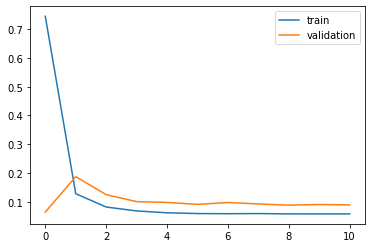


predict: [[26.65528616 22.71806287]]
real:      [[28.9 21.9]]

Train on 1028 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.0105 - mean_squared_error: 1.0854 - val_loss: 0.5298 - val_mean_squared_error: 0.3523
Epoch 2/1000
 - 0s - loss: 0.3157 - mean_squared_error: 0.1684 - val_loss: 0.1261 - val_mean_squared_error: 0.0230
Epoch 3/1000
 - 0s - loss: 0.0954 - mean_squared_error: 0.0150 - val_loss: 0.0223 - val_mean_squared_error: 5.5585e-04
Epoch 4/1000
 - 0s - loss: 0.0687 - mean_squared_error: 0.0075 - val_loss: 0.0860 - val_mean_squared_error: 0.0074
Epoch 5/1000
 - 0s - loss: 0.0618 - mean_squared_error: 0.0060 - val_loss: 0.0799 - val_mean_squared_error: 0.0069
Epoch 6/1000
 - 0s - loss: 0.0605 - mean_squared_error: 0.0061 - val_loss: 0.0519 - val_mean_squared_error: 0.0027
Epoch 7/1000
 - 0s - loss: 0.0594 - mean_squared_error: 0.0057 - val_loss: 0.0598 - val_mean_squared_error: 0.0037
Epoch 8/1000
 - 0s - loss: 0.0590 - mean_squared_error: 0.0057 - val_loss: 0.0440 

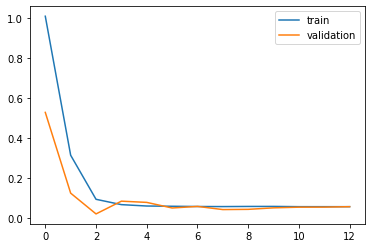


predict: [[31.93197946 22.06517053]]
real:      [[28.9 22.7]]

Train on 1027 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.8662 - mean_squared_error: 1.0859 - val_loss: 0.3253 - val_mean_squared_error: 0.1058
Epoch 2/1000
 - 0s - loss: 0.1933 - mean_squared_error: 0.0537 - val_loss: 0.1483 - val_mean_squared_error: 0.0233
Epoch 3/1000
 - 0s - loss: 0.0884 - mean_squared_error: 0.0132 - val_loss: 0.0195 - val_mean_squared_error: 7.4209e-04
Epoch 4/1000
 - 0s - loss: 0.0660 - mean_squared_error: 0.0072 - val_loss: 0.0724 - val_mean_squared_error: 0.0063
Epoch 5/1000
 - 0s - loss: 0.0616 - mean_squared_error: 0.0064 - val_loss: 0.0405 - val_mean_squared_error: 0.0021
Epoch 6/1000
 - 0s - loss: 0.0596 - mean_squared_error: 0.0059 - val_loss: 0.0397 - val_mean_squared_error: 0.0017
Epoch 7/1000
 - 0s - loss: 0.0592 - mean_squared_error: 0.0058 - val_loss: 0.0512 - val_mean_squared_error: 0.0037
Epoch 8/1000
 - 0s - loss: 0.0601 - mean_squared_error: 0.0059 - val_loss: 0.0365 

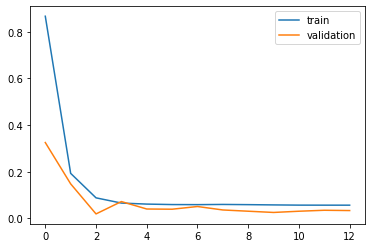


predict: [[32.32459465 22.89917541]]
real:      [[31.3 21.5]]

Train on 1026 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7591 - mean_squared_error: 0.7117 - val_loss: 0.1534 - val_mean_squared_error: 0.0282
Epoch 2/1000
 - 0s - loss: 0.1277 - mean_squared_error: 0.0286 - val_loss: 0.0366 - val_mean_squared_error: 0.0019
Epoch 3/1000
 - 0s - loss: 0.0863 - mean_squared_error: 0.0129 - val_loss: 0.1435 - val_mean_squared_error: 0.0237
Epoch 4/1000
 - 0s - loss: 0.0672 - mean_squared_error: 0.0074 - val_loss: 0.1124 - val_mean_squared_error: 0.0128
Epoch 5/1000
 - 0s - loss: 0.0617 - mean_squared_error: 0.0063 - val_loss: 0.1020 - val_mean_squared_error: 0.0104
Epoch 6/1000
 - 0s - loss: 0.0599 - mean_squared_error: 0.0060 - val_loss: 0.0993 - val_mean_squared_error: 0.0100
Epoch 7/1000
 - 0s - loss: 0.0591 - mean_squared_error: 0.0057 - val_loss: 0.0919 - val_mean_squared_error: 0.0084
Epoch 8/1000
 - 0s - loss: 0.0591 - mean_squared_error: 0.0058 - val_loss: 0.0712 - va

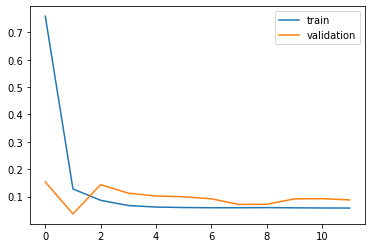


predict: [[31.14001572 22.11125593]]
real:      [[31.7 22.9]]

Train on 1025 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.8973 - mean_squared_error: 1.0483 - val_loss: 0.5304 - val_mean_squared_error: 0.3750
Epoch 2/1000
 - 0s - loss: 0.4695 - mean_squared_error: 0.3634 - val_loss: 0.2912 - val_mean_squared_error: 0.1169
Epoch 3/1000
 - 0s - loss: 0.2667 - mean_squared_error: 0.1207 - val_loss: 0.0490 - val_mean_squared_error: 0.0041
Epoch 4/1000
 - 0s - loss: 0.0924 - mean_squared_error: 0.0150 - val_loss: 0.1094 - val_mean_squared_error: 0.0165
Epoch 5/1000
 - 0s - loss: 0.0708 - mean_squared_error: 0.0081 - val_loss: 0.1207 - val_mean_squared_error: 0.0167
Epoch 6/1000
 - 0s - loss: 0.0664 - mean_squared_error: 0.0074 - val_loss: 0.0914 - val_mean_squared_error: 0.0098
Epoch 7/1000
 - 0s - loss: 0.0634 - mean_squared_error: 0.0066 - val_loss: 0.1274 - val_mean_squared_error: 0.0168
Epoch 8/1000
 - 0s - loss: 0.0609 - mean_squared_error: 0.0061 - val_loss: 0.0883 - va

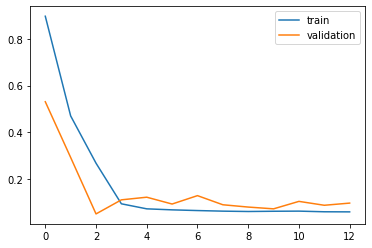


predict: [[30.77972807 22.8150693 ]]
real:      [[31.  20.8]]

Train on 1024 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7967 - mean_squared_error: 0.7907 - val_loss: 0.2224 - val_mean_squared_error: 0.0533
Epoch 2/1000
 - 0s - loss: 0.1218 - mean_squared_error: 0.0222 - val_loss: 0.0281 - val_mean_squared_error: 0.0011
Epoch 3/1000
 - 0s - loss: 0.0716 - mean_squared_error: 0.0082 - val_loss: 0.0557 - val_mean_squared_error: 0.0040
Epoch 4/1000
 - 0s - loss: 0.0634 - mean_squared_error: 0.0063 - val_loss: 0.0854 - val_mean_squared_error: 0.0077
Epoch 5/1000
 - 0s - loss: 0.0596 - mean_squared_error: 0.0058 - val_loss: 0.0686 - val_mean_squared_error: 0.0054
Epoch 6/1000
 - 0s - loss: 0.0582 - mean_squared_error: 0.0056 - val_loss: 0.0799 - val_mean_squared_error: 0.0076
Epoch 7/1000
 - 0s - loss: 0.0577 - mean_squared_error: 0.0056 - val_loss: 0.0731 - val_mean_squared_error: 0.0065
Epoch 8/1000
 - 0s - loss: 0.0572 - mean_squared_error: 0.0055 - val_loss: 0.0718 - va

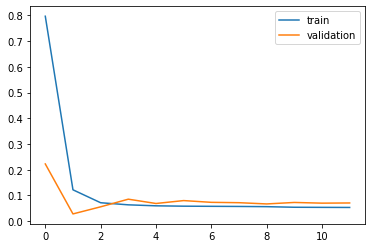


predict: [[30.43278009 20.8154535 ]]
real:      [[30.7 21. ]]

Train on 1023 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.0715 - mean_squared_error: 1.2087 - val_loss: 0.5710 - val_mean_squared_error: 0.3547
Epoch 2/1000
 - 0s - loss: 0.4040 - mean_squared_error: 0.2072 - val_loss: 0.3426 - val_mean_squared_error: 0.1198
Epoch 3/1000
 - 0s - loss: 0.1435 - mean_squared_error: 0.0312 - val_loss: 0.1291 - val_mean_squared_error: 0.0286
Epoch 4/1000
 - 0s - loss: 0.0688 - mean_squared_error: 0.0081 - val_loss: 0.0902 - val_mean_squared_error: 0.0129
Epoch 5/1000
 - 0s - loss: 0.0613 - mean_squared_error: 0.0061 - val_loss: 0.0865 - val_mean_squared_error: 0.0095
Epoch 6/1000
 - 0s - loss: 0.0605 - mean_squared_error: 0.0060 - val_loss: 0.0784 - val_mean_squared_error: 0.0093
Epoch 7/1000
 - 0s - loss: 0.0596 - mean_squared_error: 0.0059 - val_loss: 0.0737 - val_mean_squared_error: 0.0070
Epoch 8/1000
 - 0s - loss: 0.0593 - mean_squared_error: 0.0058 - val_loss: 0.0724 - va

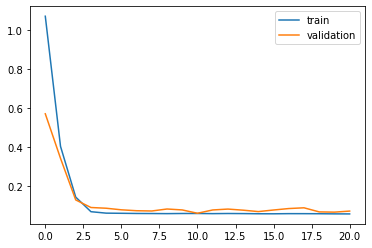


predict: [[32.13962577 22.71580254]]
real:      [[30.6 21.7]]

Train on 1022 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.4606 - mean_squared_error: 2.2265 - val_loss: 1.1280 - val_mean_squared_error: 1.2827
Epoch 2/1000
 - 0s - loss: 1.1486 - mean_squared_error: 1.3378 - val_loss: 0.8733 - val_mean_squared_error: 0.7635
Epoch 3/1000
 - 0s - loss: 0.4636 - mean_squared_error: 0.3120 - val_loss: 0.2871 - val_mean_squared_error: 0.0827
Epoch 4/1000
 - 0s - loss: 0.1248 - mean_squared_error: 0.0242 - val_loss: 0.0971 - val_mean_squared_error: 0.0095
Epoch 5/1000
 - 0s - loss: 0.0671 - mean_squared_error: 0.0071 - val_loss: 0.0702 - val_mean_squared_error: 0.0091
Epoch 6/1000
 - 0s - loss: 0.0614 - mean_squared_error: 0.0061 - val_loss: 0.0697 - val_mean_squared_error: 0.0093
Epoch 7/1000
 - 0s - loss: 0.0590 - mean_squared_error: 0.0057 - val_loss: 0.0665 - val_mean_squared_error: 0.0084
Epoch 8/1000
 - 0s - loss: 0.0588 - mean_squared_error: 0.0057 - val_loss: 0.0796 - va

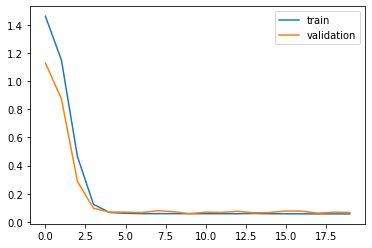


predict: [[31.9916295  22.91106202]]
real:      [[30.3 22.3]]

Train on 1021 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.0929 - mean_squared_error: 1.5508 - val_loss: 0.7551 - val_mean_squared_error: 1.0331
Epoch 2/1000
 - 0s - loss: 0.6230 - mean_squared_error: 0.7172 - val_loss: 0.3597 - val_mean_squared_error: 0.2235
Epoch 3/1000
 - 0s - loss: 0.2607 - mean_squared_error: 0.1371 - val_loss: 0.1361 - val_mean_squared_error: 0.0226
Epoch 4/1000
 - 0s - loss: 0.0856 - mean_squared_error: 0.0125 - val_loss: 0.0497 - val_mean_squared_error: 0.0043
Epoch 5/1000
 - 0s - loss: 0.0704 - mean_squared_error: 0.0081 - val_loss: 0.0598 - val_mean_squared_error: 0.0064
Epoch 6/1000
 - 0s - loss: 0.0643 - mean_squared_error: 0.0067 - val_loss: 0.0595 - val_mean_squared_error: 0.0067
Epoch 7/1000
 - 0s - loss: 0.0614 - mean_squared_error: 0.0061 - val_loss: 0.0613 - val_mean_squared_error: 0.0049
Epoch 8/1000
 - 0s - loss: 0.0616 - mean_squared_error: 0.0061 - val_loss: 0.0483 - va

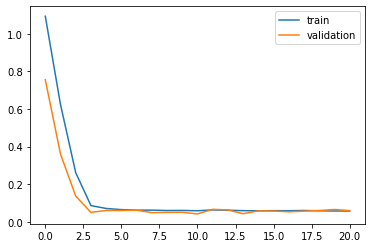


predict: [[32.39082983 23.26886436]]
real:      [[30.  23.1]]

Train on 1020 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.1065 - mean_squared_error: 1.2847 - val_loss: 0.6535 - val_mean_squared_error: 0.4292
Epoch 2/1000
 - 0s - loss: 0.3328 - mean_squared_error: 0.1650 - val_loss: 0.1367 - val_mean_squared_error: 0.0203
Epoch 3/1000
 - 0s - loss: 0.0975 - mean_squared_error: 0.0149 - val_loss: 0.1138 - val_mean_squared_error: 0.0224
Epoch 4/1000
 - 0s - loss: 0.0677 - mean_squared_error: 0.0078 - val_loss: 0.0761 - val_mean_squared_error: 0.0066
Epoch 5/1000
 - 0s - loss: 0.0619 - mean_squared_error: 0.0063 - val_loss: 0.0610 - val_mean_squared_error: 0.0050
Epoch 6/1000
 - 0s - loss: 0.0607 - mean_squared_error: 0.0060 - val_loss: 0.0514 - val_mean_squared_error: 0.0032
Epoch 7/1000
 - 0s - loss: 0.0602 - mean_squared_error: 0.0060 - val_loss: 0.0353 - val_mean_squared_error: 0.0021
Epoch 8/1000
 - 0s - loss: 0.0604 - mean_squared_error: 0.0059 - val_loss: 0.0608 - va

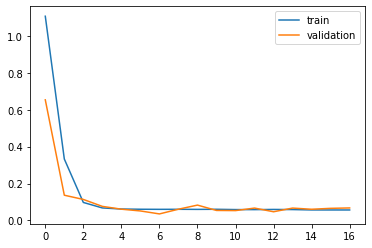


predict: [[31.97791399 22.21419374]]
real:      [[31.1 22.8]]

Train on 1019 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4736 - mean_squared_error: 0.3474 - val_loss: 0.2519 - val_mean_squared_error: 0.0690
Epoch 2/1000
 - 0s - loss: 0.1152 - mean_squared_error: 0.0204 - val_loss: 0.1099 - val_mean_squared_error: 0.0195
Epoch 3/1000
 - 0s - loss: 0.0727 - mean_squared_error: 0.0089 - val_loss: 0.0382 - val_mean_squared_error: 0.0023
Epoch 4/1000
 - 0s - loss: 0.0640 - mean_squared_error: 0.0067 - val_loss: 0.0277 - val_mean_squared_error: 0.0013
Epoch 5/1000
 - 0s - loss: 0.0623 - mean_squared_error: 0.0063 - val_loss: 0.0526 - val_mean_squared_error: 0.0042
Epoch 6/1000
 - 0s - loss: 0.0612 - mean_squared_error: 0.0061 - val_loss: 0.0487 - val_mean_squared_error: 0.0035
Epoch 7/1000
 - 0s - loss: 0.0600 - mean_squared_error: 0.0059 - val_loss: 0.0484 - val_mean_squared_error: 0.0028
Epoch 8/1000
 - 0s - loss: 0.0604 - mean_squared_error: 0.0059 - val_loss: 0.0480 - va

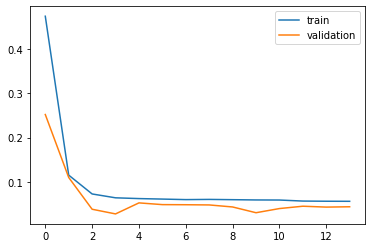


predict: [[31.69081192 23.03830504]]
real:      [[31.1 22.3]]

Train on 1018 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.0446 - mean_squared_error: 1.2678 - val_loss: 0.6323 - val_mean_squared_error: 0.6074
Epoch 2/1000
 - 0s - loss: 0.4721 - mean_squared_error: 0.4008 - val_loss: 0.0567 - val_mean_squared_error: 0.0050
Epoch 3/1000
 - 0s - loss: 0.1017 - mean_squared_error: 0.0185 - val_loss: 0.1100 - val_mean_squared_error: 0.0171
Epoch 4/1000
 - 0s - loss: 0.0709 - mean_squared_error: 0.0081 - val_loss: 0.1076 - val_mean_squared_error: 0.0118
Epoch 5/1000
 - 0s - loss: 0.0662 - mean_squared_error: 0.0072 - val_loss: 0.0809 - val_mean_squared_error: 0.0090
Epoch 6/1000
 - 0s - loss: 0.0650 - mean_squared_error: 0.0067 - val_loss: 0.0954 - val_mean_squared_error: 0.0124
Epoch 7/1000
 - 0s - loss: 0.0635 - mean_squared_error: 0.0065 - val_loss: 0.0877 - val_mean_squared_error: 0.0080
Epoch 8/1000
 - 0s - loss: 0.0598 - mean_squared_error: 0.0058 - val_loss: 0.0707 - va

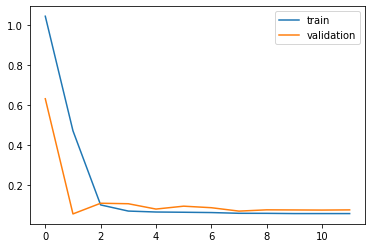


predict: [[28.35055492 22.18547242]]
real:      [[31.  22.8]]

Train on 1017 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.9006 - mean_squared_error: 1.0236 - val_loss: 0.3831 - val_mean_squared_error: 0.1504
Epoch 2/1000
 - 0s - loss: 0.2037 - mean_squared_error: 0.0731 - val_loss: 0.2147 - val_mean_squared_error: 0.0716
Epoch 3/1000
 - 0s - loss: 0.0841 - mean_squared_error: 0.0117 - val_loss: 0.1468 - val_mean_squared_error: 0.0349
Epoch 4/1000
 - 0s - loss: 0.0678 - mean_squared_error: 0.0077 - val_loss: 0.0928 - val_mean_squared_error: 0.0165
Epoch 5/1000
 - 0s - loss: 0.0622 - mean_squared_error: 0.0063 - val_loss: 0.1232 - val_mean_squared_error: 0.0245
Epoch 6/1000
 - 0s - loss: 0.0620 - mean_squared_error: 0.0063 - val_loss: 0.1237 - val_mean_squared_error: 0.0272
Epoch 7/1000
 - 0s - loss: 0.0608 - mean_squared_error: 0.0061 - val_loss: 0.1221 - val_mean_squared_error: 0.0298
Epoch 8/1000
 - 0s - loss: 0.0596 - mean_squared_error: 0.0059 - val_loss: 0.1295 - va

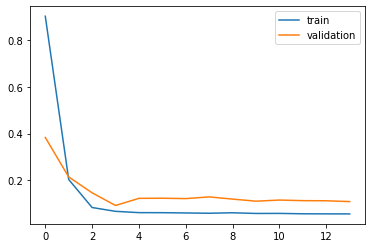


predict: [[30.77846556 21.83669288]]
real:      [[30.7 21.7]]

Train on 1016 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4295 - mean_squared_error: 0.3677 - val_loss: 0.1205 - val_mean_squared_error: 0.0268
Epoch 2/1000
 - 0s - loss: 0.1017 - mean_squared_error: 0.0177 - val_loss: 0.0682 - val_mean_squared_error: 0.0051
Epoch 3/1000
 - 0s - loss: 0.0705 - mean_squared_error: 0.0082 - val_loss: 0.1064 - val_mean_squared_error: 0.0177
Epoch 4/1000
 - 0s - loss: 0.0626 - mean_squared_error: 0.0064 - val_loss: 0.0850 - val_mean_squared_error: 0.0106
Epoch 5/1000
 - 0s - loss: 0.0629 - mean_squared_error: 0.0063 - val_loss: 0.0961 - val_mean_squared_error: 0.0155
Epoch 6/1000
 - 0s - loss: 0.0629 - mean_squared_error: 0.0065 - val_loss: 0.0832 - val_mean_squared_error: 0.0111
Epoch 7/1000
 - 0s - loss: 0.0606 - mean_squared_error: 0.0060 - val_loss: 0.0794 - val_mean_squared_error: 0.0100
Epoch 8/1000
 - 0s - loss: 0.0604 - mean_squared_error: 0.0061 - val_loss: 0.0829 - va

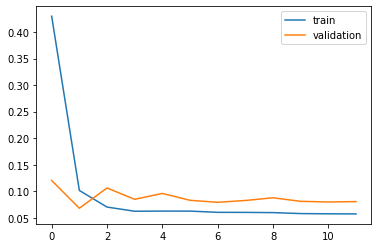


predict: [[31.57969296 23.76133389]]
real:      [[27.9 23. ]]

Train on 1015 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.5042 - mean_squared_error: 0.4202 - val_loss: 0.1898 - val_mean_squared_error: 0.0386
Epoch 2/1000
 - 0s - loss: 0.1332 - mean_squared_error: 0.0309 - val_loss: 0.1325 - val_mean_squared_error: 0.0219
Epoch 3/1000
 - 0s - loss: 0.0831 - mean_squared_error: 0.0108 - val_loss: 0.1164 - val_mean_squared_error: 0.0194
Epoch 4/1000
 - 0s - loss: 0.0696 - mean_squared_error: 0.0077 - val_loss: 0.0832 - val_mean_squared_error: 0.0081
Epoch 5/1000
 - 0s - loss: 0.0631 - mean_squared_error: 0.0065 - val_loss: 0.1077 - val_mean_squared_error: 0.0118
Epoch 6/1000
 - 0s - loss: 0.0626 - mean_squared_error: 0.0064 - val_loss: 0.0831 - val_mean_squared_error: 0.0081
Epoch 7/1000
 - 0s - loss: 0.0613 - mean_squared_error: 0.0062 - val_loss: 0.1117 - val_mean_squared_error: 0.0137
Epoch 8/1000
 - 0s - loss: 0.0614 - mean_squared_error: 0.0061 - val_loss: 0.1106 - va

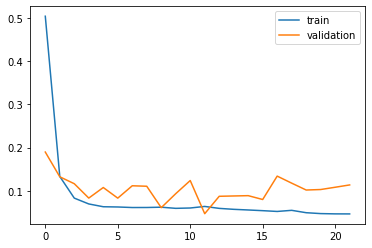


predict: [[30.68648533 21.05693733]]
real:      [[29.5 23. ]]

Train on 1014 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.5608 - mean_squared_error: 0.5081 - val_loss: 0.2236 - val_mean_squared_error: 0.0501
Epoch 2/1000
 - 0s - loss: 0.0952 - mean_squared_error: 0.0145 - val_loss: 0.1186 - val_mean_squared_error: 0.0156
Epoch 3/1000
 - 0s - loss: 0.0675 - mean_squared_error: 0.0074 - val_loss: 0.0635 - val_mean_squared_error: 0.0047
Epoch 4/1000
 - 0s - loss: 0.0620 - mean_squared_error: 0.0063 - val_loss: 0.0702 - val_mean_squared_error: 0.0050
Epoch 5/1000
 - 0s - loss: 0.0612 - mean_squared_error: 0.0061 - val_loss: 0.0720 - val_mean_squared_error: 0.0052
Epoch 6/1000
 - 0s - loss: 0.0599 - mean_squared_error: 0.0059 - val_loss: 0.0668 - val_mean_squared_error: 0.0046
Epoch 7/1000
 - 0s - loss: 0.0598 - mean_squared_error: 0.0059 - val_loss: 0.0888 - val_mean_squared_error: 0.0083
Epoch 8/1000
 - 0s - loss: 0.0593 - mean_squared_error: 0.0058 - val_loss: 0.0729 - va

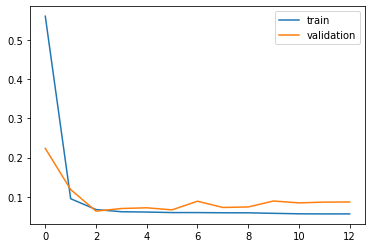


predict: [[30.30530944 22.41193059]]
real:      [[30.7 21.8]]

Train on 1013 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.8455 - mean_squared_error: 1.0554 - val_loss: 0.0918 - val_mean_squared_error: 0.0139
Epoch 2/1000
 - 0s - loss: 0.1338 - mean_squared_error: 0.0307 - val_loss: 0.2837 - val_mean_squared_error: 0.1237
Epoch 3/1000
 - 0s - loss: 0.0799 - mean_squared_error: 0.0104 - val_loss: 0.2193 - val_mean_squared_error: 0.0625
Epoch 4/1000
 - 0s - loss: 0.0685 - mean_squared_error: 0.0078 - val_loss: 0.1952 - val_mean_squared_error: 0.0516
Epoch 5/1000
 - 0s - loss: 0.0626 - mean_squared_error: 0.0063 - val_loss: 0.2006 - val_mean_squared_error: 0.0567
Epoch 6/1000
 - 0s - loss: 0.0614 - mean_squared_error: 0.0061 - val_loss: 0.2093 - val_mean_squared_error: 0.0571
Epoch 7/1000
 - 0s - loss: 0.0603 - mean_squared_error: 0.0059 - val_loss: 0.2007 - val_mean_squared_error: 0.0553
Epoch 8/1000
 - 0s - loss: 0.0594 - mean_squared_error: 0.0058 - val_loss: 0.1975 - va

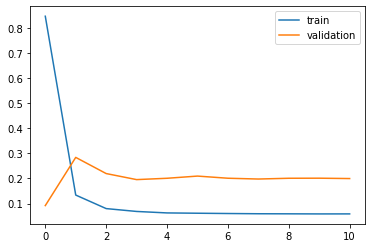


predict: [[24.37608376 23.95418217]]
real:      [[31.3 20.9]]

Train on 1012 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.9767 - mean_squared_error: 1.3619 - val_loss: 0.4798 - val_mean_squared_error: 0.2688
Epoch 2/1000
 - 0s - loss: 0.2480 - mean_squared_error: 0.1219 - val_loss: 0.2170 - val_mean_squared_error: 0.0660
Epoch 3/1000
 - 0s - loss: 0.0915 - mean_squared_error: 0.0133 - val_loss: 0.1563 - val_mean_squared_error: 0.0318
Epoch 4/1000
 - 0s - loss: 0.0693 - mean_squared_error: 0.0078 - val_loss: 0.1180 - val_mean_squared_error: 0.0159
Epoch 5/1000
 - 0s - loss: 0.0644 - mean_squared_error: 0.0067 - val_loss: 0.1119 - val_mean_squared_error: 0.0136
Epoch 6/1000
 - 0s - loss: 0.0623 - mean_squared_error: 0.0063 - val_loss: 0.1131 - val_mean_squared_error: 0.0141
Epoch 7/1000
 - 0s - loss: 0.0636 - mean_squared_error: 0.0065 - val_loss: 0.1311 - val_mean_squared_error: 0.0192
Epoch 8/1000
 - 0s - loss: 0.0614 - mean_squared_error: 0.0061 - val_loss: 0.1120 - va

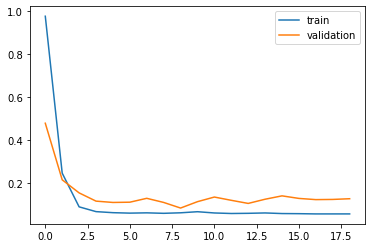


predict: [[30.00177363 19.77458839]]
real:      [[25.9 21.2]]

Train on 1011 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.2886 - mean_squared_error: 1.8811 - val_loss: 0.5686 - val_mean_squared_error: 0.3763
Epoch 2/1000
 - 0s - loss: 0.3972 - mean_squared_error: 0.2342 - val_loss: 0.2420 - val_mean_squared_error: 0.1109
Epoch 3/1000
 - 0s - loss: 0.2557 - mean_squared_error: 0.0891 - val_loss: 0.1653 - val_mean_squared_error: 0.0519
Epoch 4/1000
 - 0s - loss: 0.1832 - mean_squared_error: 0.0410 - val_loss: 0.1073 - val_mean_squared_error: 0.0133
Epoch 5/1000
 - 0s - loss: 0.1265 - mean_squared_error: 0.0231 - val_loss: 0.0956 - val_mean_squared_error: 0.0110
Epoch 6/1000
 - 0s - loss: 0.0832 - mean_squared_error: 0.0106 - val_loss: 0.0756 - val_mean_squared_error: 0.0057
Epoch 7/1000
 - 0s - loss: 0.0646 - mean_squared_error: 0.0067 - val_loss: 0.0815 - val_mean_squared_error: 0.0078
Epoch 8/1000
 - 0s - loss: 0.0633 - mean_squared_error: 0.0066 - val_loss: 0.0800 - va

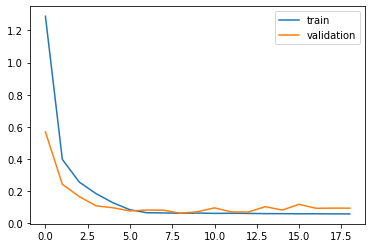


predict: [[32.29077169 21.55678206]]
real:      [[29.2 21.1]]

Train on 1010 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4848 - mean_squared_error: 0.3662 - val_loss: 0.2837 - val_mean_squared_error: 0.1020
Epoch 2/1000
 - 0s - loss: 0.1006 - mean_squared_error: 0.0163 - val_loss: 0.0876 - val_mean_squared_error: 0.0149
Epoch 3/1000
 - 0s - loss: 0.0676 - mean_squared_error: 0.0075 - val_loss: 0.1253 - val_mean_squared_error: 0.0248
Epoch 4/1000
 - 0s - loss: 0.0609 - mean_squared_error: 0.0061 - val_loss: 0.1144 - val_mean_squared_error: 0.0237
Epoch 5/1000
 - 0s - loss: 0.0597 - mean_squared_error: 0.0060 - val_loss: 0.0971 - val_mean_squared_error: 0.0180
Epoch 6/1000
 - 0s - loss: 0.0576 - mean_squared_error: 0.0055 - val_loss: 0.1101 - val_mean_squared_error: 0.0199
Epoch 7/1000
 - 0s - loss: 0.0558 - mean_squared_error: 0.0054 - val_loss: 0.1102 - val_mean_squared_error: 0.0212
Epoch 8/1000
 - 0s - loss: 0.0557 - mean_squared_error: 0.0054 - val_loss: 0.0972 - va

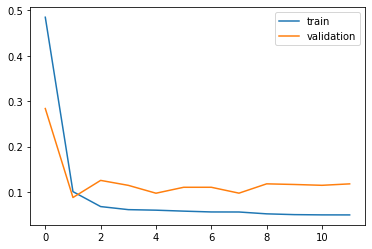


predict: [[32.25924612 22.30709504]]
real:      [[31.1 21.7]]

Train on 1009 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.8125 - mean_squared_error: 0.8976 - val_loss: 0.3025 - val_mean_squared_error: 0.1055
Epoch 2/1000
 - 0s - loss: 0.1647 - mean_squared_error: 0.0524 - val_loss: 0.1202 - val_mean_squared_error: 0.0216
Epoch 3/1000
 - 0s - loss: 0.0768 - mean_squared_error: 0.0096 - val_loss: 0.0908 - val_mean_squared_error: 0.0127
Epoch 4/1000
 - 0s - loss: 0.0689 - mean_squared_error: 0.0080 - val_loss: 0.0610 - val_mean_squared_error: 0.0046
Epoch 5/1000
 - 0s - loss: 0.0622 - mean_squared_error: 0.0064 - val_loss: 0.0724 - val_mean_squared_error: 0.0081
Epoch 6/1000
 - 0s - loss: 0.0600 - mean_squared_error: 0.0059 - val_loss: 0.0625 - val_mean_squared_error: 0.0050
Epoch 7/1000
 - 0s - loss: 0.0616 - mean_squared_error: 0.0062 - val_loss: 0.0383 - val_mean_squared_error: 0.0023
Epoch 8/1000
 - 0s - loss: 0.0604 - mean_squared_error: 0.0062 - val_loss: 0.0486 - va

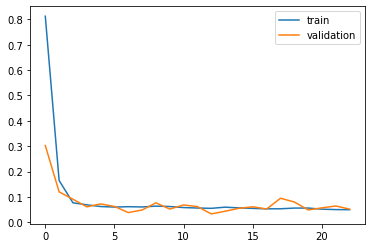


predict: [[31.06597259 21.11940618]]
real:      [[28.7 23.2]]

Train on 1008 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7901 - mean_squared_error: 0.7097 - val_loss: 0.2333 - val_mean_squared_error: 0.0568
Epoch 2/1000
 - 0s - loss: 0.1381 - mean_squared_error: 0.0279 - val_loss: 0.0568 - val_mean_squared_error: 0.0038
Epoch 3/1000
 - 0s - loss: 0.0781 - mean_squared_error: 0.0094 - val_loss: 0.0525 - val_mean_squared_error: 0.0043
Epoch 4/1000
 - 0s - loss: 0.0652 - mean_squared_error: 0.0069 - val_loss: 0.0587 - val_mean_squared_error: 0.0055
Epoch 5/1000
 - 0s - loss: 0.0608 - mean_squared_error: 0.0060 - val_loss: 0.0652 - val_mean_squared_error: 0.0050
Epoch 6/1000
 - 0s - loss: 0.0608 - mean_squared_error: 0.0061 - val_loss: 0.0520 - val_mean_squared_error: 0.0036
Epoch 7/1000
 - 0s - loss: 0.0599 - mean_squared_error: 0.0059 - val_loss: 0.0497 - val_mean_squared_error: 0.0033
Epoch 8/1000
 - 0s - loss: 0.0598 - mean_squared_error: 0.0058 - val_loss: 0.0574 - va

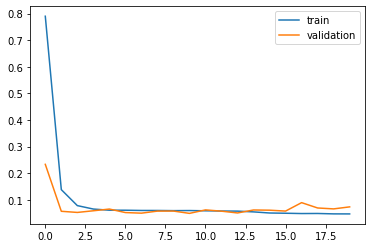


predict: [[31.89261154 22.61482332]]
real:      [[31.2 22.3]]

Train on 1007 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.5745 - mean_squared_error: 0.4643 - val_loss: 0.2312 - val_mean_squared_error: 0.0691
Epoch 2/1000
 - 0s - loss: 0.1302 - mean_squared_error: 0.0265 - val_loss: 0.0975 - val_mean_squared_error: 0.0141
Epoch 3/1000
 - 0s - loss: 0.0758 - mean_squared_error: 0.0086 - val_loss: 0.0766 - val_mean_squared_error: 0.0076
Epoch 4/1000
 - 0s - loss: 0.0635 - mean_squared_error: 0.0065 - val_loss: 0.0408 - val_mean_squared_error: 0.0026
Epoch 5/1000
 - 0s - loss: 0.0611 - mean_squared_error: 0.0061 - val_loss: 0.0399 - val_mean_squared_error: 0.0028
Epoch 6/1000
 - 0s - loss: 0.0603 - mean_squared_error: 0.0059 - val_loss: 0.0466 - val_mean_squared_error: 0.0038
Epoch 7/1000
 - 0s - loss: 0.0598 - mean_squared_error: 0.0058 - val_loss: 0.0585 - val_mean_squared_error: 0.0059
Epoch 8/1000
 - 0s - loss: 0.0588 - mean_squared_error: 0.0057 - val_loss: 0.0588 - va

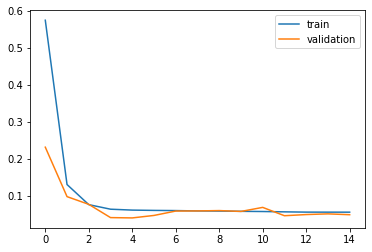


predict: [[31.7531299  22.54266469]]
real:      [[31.1 22.3]]

Train on 1006 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.9757 - mean_squared_error: 1.4112 - val_loss: 0.5028 - val_mean_squared_error: 0.4860
Epoch 2/1000
 - 0s - loss: 0.2983 - mean_squared_error: 0.2187 - val_loss: 0.2130 - val_mean_squared_error: 0.0735
Epoch 3/1000
 - 0s - loss: 0.1054 - mean_squared_error: 0.0199 - val_loss: 0.0057 - val_mean_squared_error: 3.7679e-05
Epoch 4/1000
 - 0s - loss: 0.0688 - mean_squared_error: 0.0079 - val_loss: 0.0433 - val_mean_squared_error: 0.0029
Epoch 5/1000
 - 0s - loss: 0.0622 - mean_squared_error: 0.0063 - val_loss: 0.0582 - val_mean_squared_error: 0.0053
Epoch 6/1000
 - 0s - loss: 0.0599 - mean_squared_error: 0.0059 - val_loss: 0.0512 - val_mean_squared_error: 0.0027
Epoch 7/1000
 - 0s - loss: 0.0596 - mean_squared_error: 0.0057 - val_loss: 0.0459 - val_mean_squared_error: 0.0024
Epoch 8/1000
 - 0s - loss: 0.0574 - mean_squared_error: 0.0054 - val_loss: 0.0369 

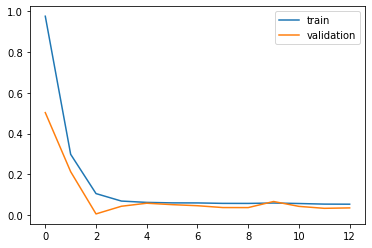


predict: [[31.1764775  22.51731666]]
real:      [[31.  22.8]]

Train on 1005 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.9497 - mean_squared_error: 1.0703 - val_loss: 0.5411 - val_mean_squared_error: 0.3625
Epoch 2/1000
 - 0s - loss: 0.2797 - mean_squared_error: 0.1370 - val_loss: 0.1079 - val_mean_squared_error: 0.0129
Epoch 3/1000
 - 0s - loss: 0.0913 - mean_squared_error: 0.0130 - val_loss: 0.0634 - val_mean_squared_error: 0.0043
Epoch 4/1000
 - 0s - loss: 0.0659 - mean_squared_error: 0.0069 - val_loss: 0.0290 - val_mean_squared_error: 9.2063e-04
Epoch 5/1000
 - 0s - loss: 0.0608 - mean_squared_error: 0.0061 - val_loss: 0.0246 - val_mean_squared_error: 0.0010
Epoch 6/1000
 - 0s - loss: 0.0603 - mean_squared_error: 0.0060 - val_loss: 0.0299 - val_mean_squared_error: 0.0013
Epoch 7/1000
 - 0s - loss: 0.0596 - mean_squared_error: 0.0058 - val_loss: 0.0370 - val_mean_squared_error: 0.0024
Epoch 8/1000
 - 0s - loss: 0.0587 - mean_squared_error: 0.0056 - val_loss: 0.0469 

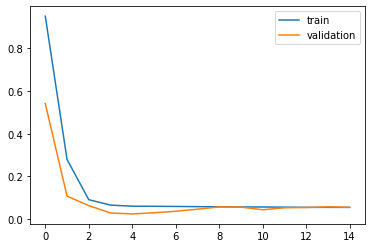


predict: [[30.69584428 22.50154461]]
real:      [[31.5 23. ]]

Train on 1004 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.9711 - mean_squared_error: 1.1104 - val_loss: 0.3937 - val_mean_squared_error: 0.1565
Epoch 2/1000
 - 0s - loss: 0.1873 - mean_squared_error: 0.0651 - val_loss: 0.1746 - val_mean_squared_error: 0.0338
Epoch 3/1000
 - 0s - loss: 0.0799 - mean_squared_error: 0.0105 - val_loss: 0.0344 - val_mean_squared_error: 0.0013
Epoch 4/1000
 - 0s - loss: 0.0677 - mean_squared_error: 0.0075 - val_loss: 0.0874 - val_mean_squared_error: 0.0115
Epoch 5/1000
 - 0s - loss: 0.0639 - mean_squared_error: 0.0068 - val_loss: 0.0553 - val_mean_squared_error: 0.0045
Epoch 6/1000
 - 0s - loss: 0.0620 - mean_squared_error: 0.0063 - val_loss: 0.0558 - val_mean_squared_error: 0.0056
Epoch 7/1000
 - 0s - loss: 0.0622 - mean_squared_error: 0.0063 - val_loss: 0.0556 - val_mean_squared_error: 0.0033
Epoch 8/1000
 - 0s - loss: 0.0614 - mean_squared_error: 0.0061 - val_loss: 0.0452 - va

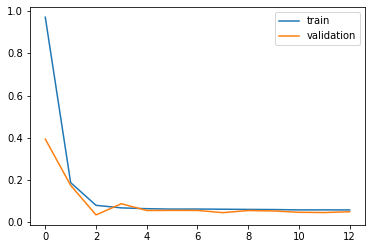


predict: [[31.94178835 22.40396384]]
real:      [[30.9 22.9]]

Train on 1003 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.8730 - mean_squared_error: 1.1194 - val_loss: 0.6147 - val_mean_squared_error: 0.5117
Epoch 2/1000
 - 0s - loss: 0.3579 - mean_squared_error: 0.2563 - val_loss: 0.1379 - val_mean_squared_error: 0.0190
Epoch 3/1000
 - 0s - loss: 0.0962 - mean_squared_error: 0.0171 - val_loss: 0.0835 - val_mean_squared_error: 0.0070
Epoch 4/1000
 - 0s - loss: 0.0706 - mean_squared_error: 0.0082 - val_loss: 0.1302 - val_mean_squared_error: 0.0205
Epoch 5/1000
 - 0s - loss: 0.0646 - mean_squared_error: 0.0070 - val_loss: 0.1058 - val_mean_squared_error: 0.0116
Epoch 6/1000
 - 0s - loss: 0.0611 - mean_squared_error: 0.0061 - val_loss: 0.1125 - val_mean_squared_error: 0.0127
Epoch 7/1000
 - 0s - loss: 0.0604 - mean_squared_error: 0.0059 - val_loss: 0.0931 - val_mean_squared_error: 0.0087
Epoch 8/1000
 - 0s - loss: 0.0594 - mean_squared_error: 0.0057 - val_loss: 0.0963 - va

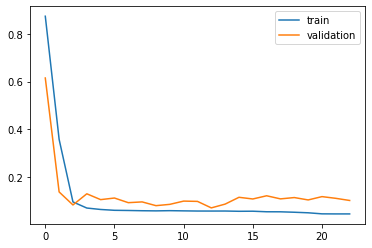


predict: [[31.50458848 21.99071847]]
real:      [[31.2 23.2]]

Train on 1002 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.0408 - mean_squared_error: 1.2039 - val_loss: 0.3535 - val_mean_squared_error: 0.1261
Epoch 2/1000
 - 0s - loss: 0.2241 - mean_squared_error: 0.0825 - val_loss: 0.2625 - val_mean_squared_error: 0.1265
Epoch 3/1000
 - 0s - loss: 0.0970 - mean_squared_error: 0.0174 - val_loss: 0.0840 - val_mean_squared_error: 0.0123
Epoch 4/1000
 - 0s - loss: 0.0726 - mean_squared_error: 0.0092 - val_loss: 0.1253 - val_mean_squared_error: 0.0276
Epoch 5/1000
 - 0s - loss: 0.0638 - mean_squared_error: 0.0066 - val_loss: 0.1250 - val_mean_squared_error: 0.0250
Epoch 6/1000
 - 0s - loss: 0.0610 - mean_squared_error: 0.0061 - val_loss: 0.0875 - val_mean_squared_error: 0.0147
Epoch 7/1000
 - 0s - loss: 0.0593 - mean_squared_error: 0.0057 - val_loss: 0.1051 - val_mean_squared_error: 0.0204
Epoch 8/1000
 - 0s - loss: 0.0592 - mean_squared_error: 0.0058 - val_loss: 0.0946 - va

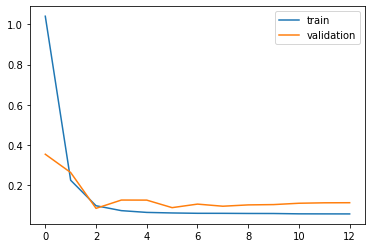


predict: [[32.26336448 22.20993511]]
real:      [[31.  21.1]]

Train on 1001 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.2788 - mean_squared_error: 1.9899 - val_loss: 1.0832 - val_mean_squared_error: 1.8422
Epoch 2/1000
 - 0s - loss: 1.0717 - mean_squared_error: 2.0006 - val_loss: 0.8375 - val_mean_squared_error: 1.2716
Epoch 3/1000
 - 0s - loss: 0.7535 - mean_squared_error: 1.0728 - val_loss: 0.4196 - val_mean_squared_error: 0.3062
Epoch 4/1000
 - 0s - loss: 0.2671 - mean_squared_error: 0.1639 - val_loss: 0.1811 - val_mean_squared_error: 0.0523
Epoch 5/1000
 - 0s - loss: 0.1026 - mean_squared_error: 0.0190 - val_loss: 0.0582 - val_mean_squared_error: 0.0039
Epoch 6/1000
 - 0s - loss: 0.0749 - mean_squared_error: 0.0091 - val_loss: 0.1225 - val_mean_squared_error: 0.0269
Epoch 7/1000
 - 0s - loss: 0.0667 - mean_squared_error: 0.0072 - val_loss: 0.0832 - val_mean_squared_error: 0.0121
Epoch 8/1000
 - 0s - loss: 0.0642 - mean_squared_error: 0.0067 - val_loss: 0.0832 - va

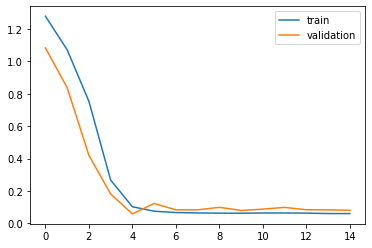


predict: [[31.7320908  22.15639511]]
real:      [[28.7 22.8]]

Train on 1000 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.8913 - mean_squared_error: 0.9507 - val_loss: 0.2206 - val_mean_squared_error: 0.0532
Epoch 2/1000
 - 0s - loss: 0.1413 - mean_squared_error: 0.0307 - val_loss: 0.0234 - val_mean_squared_error: 6.4752e-04
Epoch 3/1000
 - 0s - loss: 0.0892 - mean_squared_error: 0.0127 - val_loss: 0.0569 - val_mean_squared_error: 0.0034
Epoch 4/1000
 - 0s - loss: 0.0669 - mean_squared_error: 0.0073 - val_loss: 0.0923 - val_mean_squared_error: 0.0100
Epoch 5/1000
 - 0s - loss: 0.0625 - mean_squared_error: 0.0064 - val_loss: 0.0803 - val_mean_squared_error: 0.0089
Epoch 6/1000
 - 0s - loss: 0.0625 - mean_squared_error: 0.0064 - val_loss: 0.0904 - val_mean_squared_error: 0.0105
Epoch 7/1000
 - 0s - loss: 0.0619 - mean_squared_error: 0.0063 - val_loss: 0.0850 - val_mean_squared_error: 0.0090
Epoch 8/1000
 - 0s - loss: 0.0614 - mean_squared_error: 0.0062 - val_loss: 0.0761 

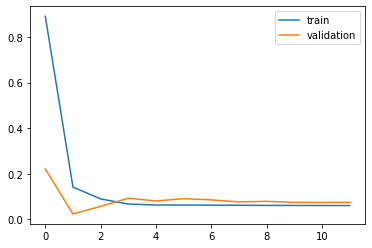


predict: [[29.9573504  21.80696314]]
real:      [[30.1 22.9]]

Maximum temperature
Test RMSE -------------------------- 2.197
Test VARIANCE ---------------------- -1.711
Test MAX-ERROR --------------------- 6.924
Test MEAN-ABSOLUTE-ERROR ----------- 1.606
Test MEDIAN-ABSOLUTE-ERROR --------- 1.101
Minimum temperature
Test RMSE -------------------------- 1.103
Test VARIANCE ---------------------- -1.033
Test MAX-ERROR --------------------- 3.054
Test MEAN-ABSOLUTE-ERROR ----------- 0.8847
Test MEDIAN-ABSOLUTE-ERROR --------- 0.6392


In [11]:
# to get index the last 30 days
days_to_predict = list(dataset.index[-30:])

mean_scaler = np.mean(values) + 1
dataset_scaled = dataset.div(mean_scaler)

NCV(dataset_scaled, days_to_predict, mean_scaler)